Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

Just make sure:

    to add enough Markdown cells to explain what you decided to do and to report any observations you make.
    to generate maps to visualize your neighborhoods and how they cluster together. 

In [27]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import requests
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


Using beautiful soup to parse xml data from Wikipedia webpage.
Then, finding the table and iterating through it's elements to parse data.
Data from the table is stored in dataframe df.

In [28]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
soup = BeautifulSoup(source, 'xml')
table=soup.find('table')
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)
# Search all the postcode, borough, neighborhood 
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data
# preprocessing
df = df[df['Borough']!=('Not assigned')]
df = df[df['Borough']!=('')]
df['Neighborhood'] = np.where(df['Neighborhood']=='Not assigned',df['Borough'], df['Neighborhood'])
geospacial_data = pd.read_csv('Geospatial_Coordinates.csv')
df = df.merge(geospacial_data, left_on='Postalcode', right_on='Postal Code')
df.drop(columns = ["Postalcode", "Postal Code"], inplace = True)
neighborhoods = df
neighborhoods.Borough.unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [29]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [30]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Toronto are 43.6534817, -79.3839347.


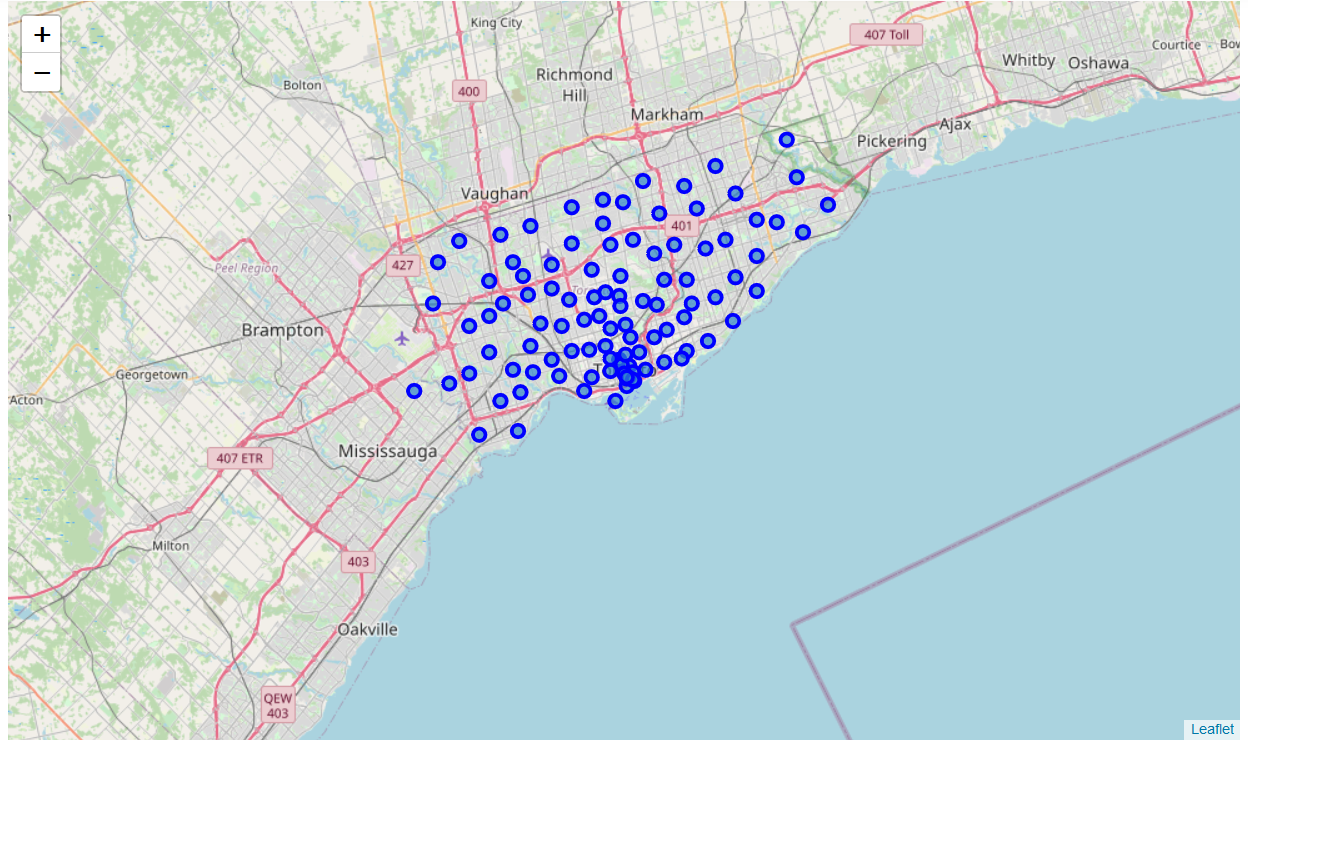

In [31]:
# creating a map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
from IPython.display import Image
Image(filename='map1.png') 

In [32]:
toronto_data = neighborhoods[(neighborhoods['Borough']=='Downtown Toronto')|
                             (neighborhoods['Borough']=='East Toronto')|
                             (neighborhoods['Borough']=='West Toronto')|
                             (neighborhoods['Borough']=='Central Toronto')].reset_index(drop=True)
toronto_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,Downtown Toronto,St. James Town,43.651494,-79.375418
4,East Toronto,The Beaches,43.676357,-79.293031


In [33]:
CLIENT_ID = 'MM2CUS22DQJMTI1IIVJDWKZIASVV2ILTAV5WOJC4EGC3JTTI' # your Foursquare ID
CLIENT_SECRET = '3EWZKMTQOFBZEYUSWSZY2KNJ1LQHZKAD3ME2NQUTLTRX3VEV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MM2CUS22DQJMTI1IIVJDWKZIASVV2ILTAV5WOJC4EGC3JTTI
CLIENT_SECRET:3EWZKMTQOFBZEYUSWSZY2KNJ1LQHZKAD3ME2NQUTLTRX3VEV


In [34]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))
radius='500'
LIMIT = '100'

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


In [35]:
# type your answer here
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [36]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [37]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149
3,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
4,Body Blitz Spa East,Spa,43.654735,-79.359874


In [38]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

47 venues were returned by Foursquare.


In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [41]:
print(toronto_venues.shape)
toronto_venues.head()

(1612, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [42]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,64,64,64,64,64,64


In [43]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 240 uniques categories.


In [44]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.shape

(1612, 240)

In [45]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Cable Car,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Transportation Service,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.035088,0.000000,0.000000,0.00,0.017544,0.017544,0.000000,0.035088,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.00000,0.017544,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.00000,0.000000,0.017544,0.052632,0.070175,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.017544,0.0

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Bakery,Seafood Restaurant,Restaurant,Cheese Shop,Café,Gourmet Shop,Japanese Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Nightclub,Breakfast Spot,Coffee Shop,Performing Arts Venue,Restaurant,Bakery,Stadium,Intersection,Italian Restaurant
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Pizza Place,Restaurant,Fast Food Restaurant,Farmers Market,Skate Park,Auto Workshop,Burrito Place,Spa,Brewery
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Coffee Shop,Airport Terminal,Plane,Harbor / Marina,Bar,Boat or Ferry,Sculpture Garden,Airport Gate
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Ice Cream Shop,Japanese Restaurant,Salad Place,Thai Restaurant,Bubble Tea Shop,Burger Joint


# 4. Cluster Neighborhoods

In [48]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Restaurant,Café,Theater,Mexican Restaurant,Shoe Store
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,Park,College Auditorium,College Cafeteria
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Cosmetics Shop,Italian Restaurant,Middle Eastern Restaurant,Japanese Restaurant,Café,Restaurant,Bubble Tea Shop,Diner
3,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Coffee Shop,Cocktail Bar,Restaurant,Gastropub,American Restaurant,Italian Restaurant,Gym,Department Store,Clothing Store
4,East Toronto,The Beaches,43.676357,-79.293031,4,Trail,Pub,Health Food Store,Women's Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Cuban Restaurant


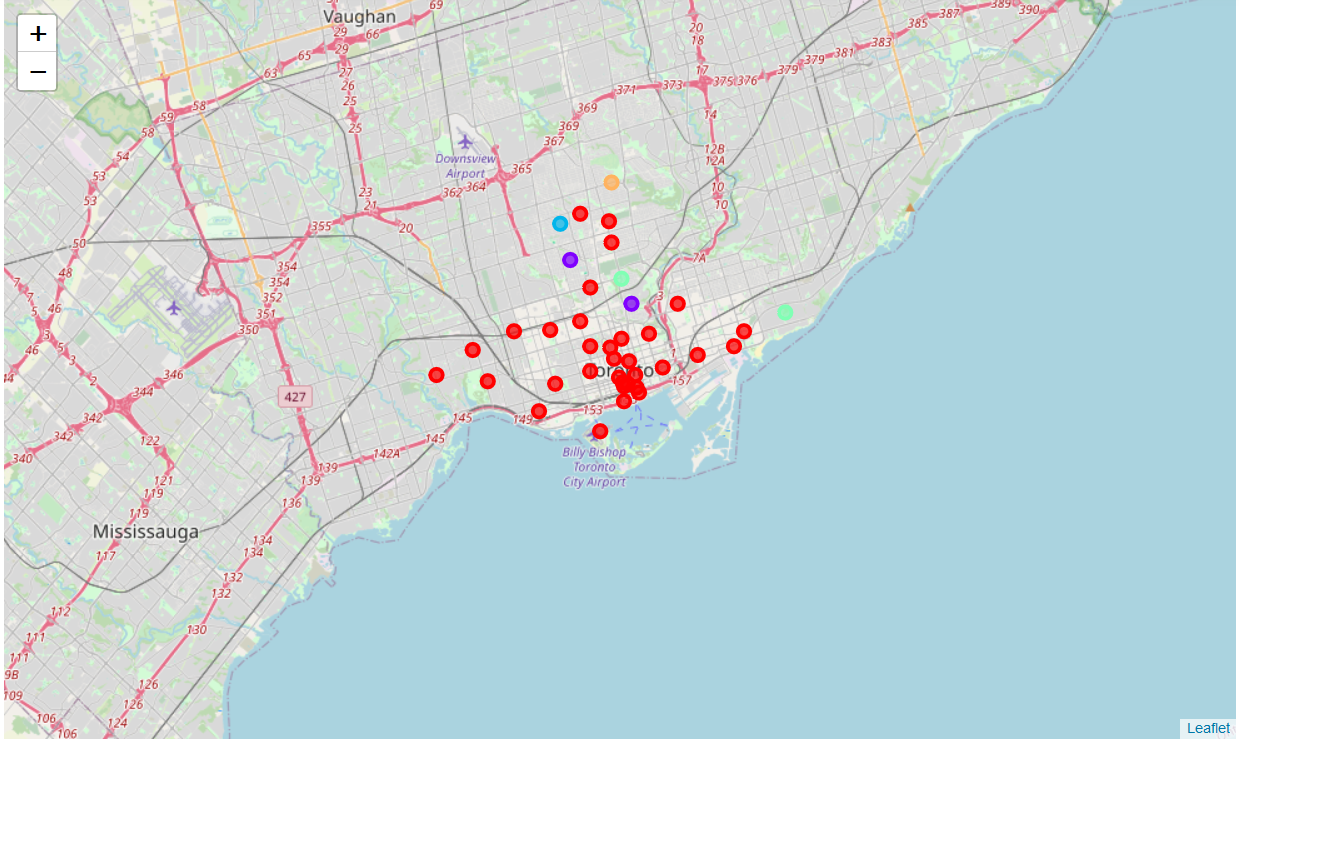

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
# map_clusters
from IPython.display import Image
Image(filename='map2.png') 